In [1]:
import shutil
shutil.rmtree('gallirallus')

platform = 'colab'
if platform == 'colab':
    ! pip install nilearn==0.9.2
    ! git clone https://github.com/mkmohan003/gallirallus.git

Cloning into 'gallirallus'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 44 (delta 12), reused 21 (delta 3), pack-reused 0
Unpacking objects: 100% (44/44), 1.96 MiB | 983.00 KiB/s, done.


### 0.1.3 Import the libraries

Once you have installed all necessary libraries, import them with the following code.

In [2]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib
from matplotlib import pyplot as plt
from nilearn import datasets
from nilearn import plotting
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr

import gallirallus.dataops.nsd as nsd

## 0.2 Access the tutorial data

In [3]:
if platform == 'colab':
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    data_dir = '/content/drive/MyDrive/algonauts_2023_tutorial_data'
    parent_submission_dir = '/content/drive/MyDrive/algonauts_2023_challenge_submission'
else:
    data_dir = '../algonauts_2023_challenge_data'
    parent_submission_dir = '../algonauts_2023_challenge_submission'

Mounted at /content/drive/


In [4]:
device = 'cuda'
device = torch.device(device)
subj = 1

## 1.1 Define paths

Let's define some paths that we will need for loading and storing data.

In [5]:
class argObj:
  def __init__(self, data_dir, subj):

    self.subj = format(subj, '02')
    self.data_dir = os.path.join(data_dir, 'subj'+self.subj)

args = argObj(data_dir, subj)

## 1.2 Load the fMRI training data

In [6]:
fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

print('LH training fMRI data shape:')
print(lh_fmri.shape)
print('(Training stimulus images × LH vertices)')

print('\nRH training fMRI data shape:')
print(rh_fmri.shape)
print('(Training stimulus images × RH vertices)')

LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)


# 1.3 Load Images

In [7]:
train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
test_img_dir  = os.path.join(args.data_dir, 'test_split', 'test_images')

# Create lists will all training and test image file names, sorted
train_img_list = os.listdir(train_img_dir)
train_img_list.sort()
test_img_list = os.listdir(test_img_dir)
test_img_list.sort()
print('Training images: ' + str(len(train_img_list)))
print('Test images: ' + str(len(test_img_list)))

Training images: 9841
Test images: 159


In [8]:
train_img_file = train_img_list[0]
print('Training image file name: ' + train_img_file)
print('73k NSD images ID: ' + train_img_file[-9:-4])

Training image file name: train-0001_nsd-00013.png
73k NSD images ID: 00013


### 2.1.1 Create the training, validation and test partitions indices

Here you will create the indices to randomly split the training data into a training (90% of the data) and validation (10% of the data) partition. You can enforce different random splits by editing the random seed variable (`rand_seed`).

In [9]:
rand_seed = 5
np.random.seed(rand_seed)
subset = 1000
batch_size = 100
use_subset = True

if use_subset:
  n = subset
else:
  n = len(train_img_list)

# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(n / 100 * 90))
# Shuffle all training stimulus images
idxs = np.arange(n)
np.random.shuffle(idxs)
# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]
# No need to shuffle or split the test stimulus images
idxs_test = np.arange(len(test_img_list))

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nValidation stimulus images: ' + format(len(idxs_val)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

Training stimulus images: 900

Validation stimulus images: 100

Test stimulus images: 159


### 2.1.2 Create the training, validation and test image partitions DataLoaders

In [10]:
transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x24 pixels
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
])

Now we define a Dataset class that will load, preprocess, and return an image at a time.

In [11]:
class ImageDataset(Dataset):
    def __init__(self, imgs_paths, idxs, transform):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(device)
        return img

We will now create a DataLoader class that allow us to iterate over batches of images. We use batches because loading and processing all images at once uses too much memory.

In [12]:
# Get the paths of all image files
train_imgs_paths = sorted(list(Path(train_img_dir).iterdir()))
test_imgs_paths = sorted(list(Path(test_img_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_train, transform),
    batch_size=batch_size
)
val_imgs_dataloader = DataLoader(
    ImageDataset(train_imgs_paths, idxs_val, transform),
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(test_imgs_paths, idxs_test, transform),
    batch_size=batch_size
)

### 2.1.3 Split the fMRI data into training and validation partitions

Here we will use the previously defined indices to split the training fMRI data into a training and validation partition.

In [13]:
lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_val = lh_fmri[idxs_val]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_val = rh_fmri[idxs_val]

### 2.2.1 Load the pretrained AlexNet

We will load the pretrained AlexNet from the [PyTorch Hub][pytorch_hub] and set it to evaluation mode since we will not be training this network.

[pytorch_hub]: https://pytorch.org/hub/

In [14]:
device = 'cpu'
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

AlexNet is composed of 5 convolutional layers (contained in a submodule called 'features') and 3 linear layers (contained in a submodule named 'classifier').

First let's print the AlexNet layer names of the PyTorch implementation.

In [15]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


### 2.2.2 Extract and downsample the AlexNet features

We will now extract the image features of an AlexNet layer of your choice, and reduce their size using PCA.

To extract the features, we will use the PyTorch function [`create_feature_extractor`][extract_feat].

First, choose the AlexNet layer you wish to use.

[extract_feat]: https://pytorch.org/vision/stable/feature_extraction.html

In [16]:
model_layer = "features.2" # ["features.2", "features.5", "features.7", "features.9", "features.12", "classifier.2", "classifier.5", "classifier.6"] {allow-input: true}
feature_extractor = create_feature_extractor(model, return_nodes=[model_layer])

In [17]:
def fit_pca(feature_extractor, dataloader, n_comp):
    # Define PCA parameters
    pca = IncrementalPCA(n_components=n_comp, batch_size=batch_size)

    # Fit PCA to batch
    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        # Flatten the features
        ft = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        # Fit PCA to batch
        pca.partial_fit(ft.detach().cpu().numpy())
    return pca

In [18]:
# Iterate over list of n_components for the PCA
# In principle it is possible to fit all components you can (limited by batch size)
# and only after pick how many initial ones to use for transformation.
# separate fits almost copy each other.
pca_dict = {}
for n in [10, 40, 80]:
  pca = fit_pca(feature_extractor, train_imgs_dataloader, n_comp=n)
  pca_dict[n] = pca

100%|██████████| 9/9 [00:55<00:00,  6.12s/it]


100%|██████████| 20544/20544 [00:27<00:00, 753.58it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 20544/20544 [00:25<00:00, 802.89it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 20544/20544 [00:26<00:00, 762.66it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10

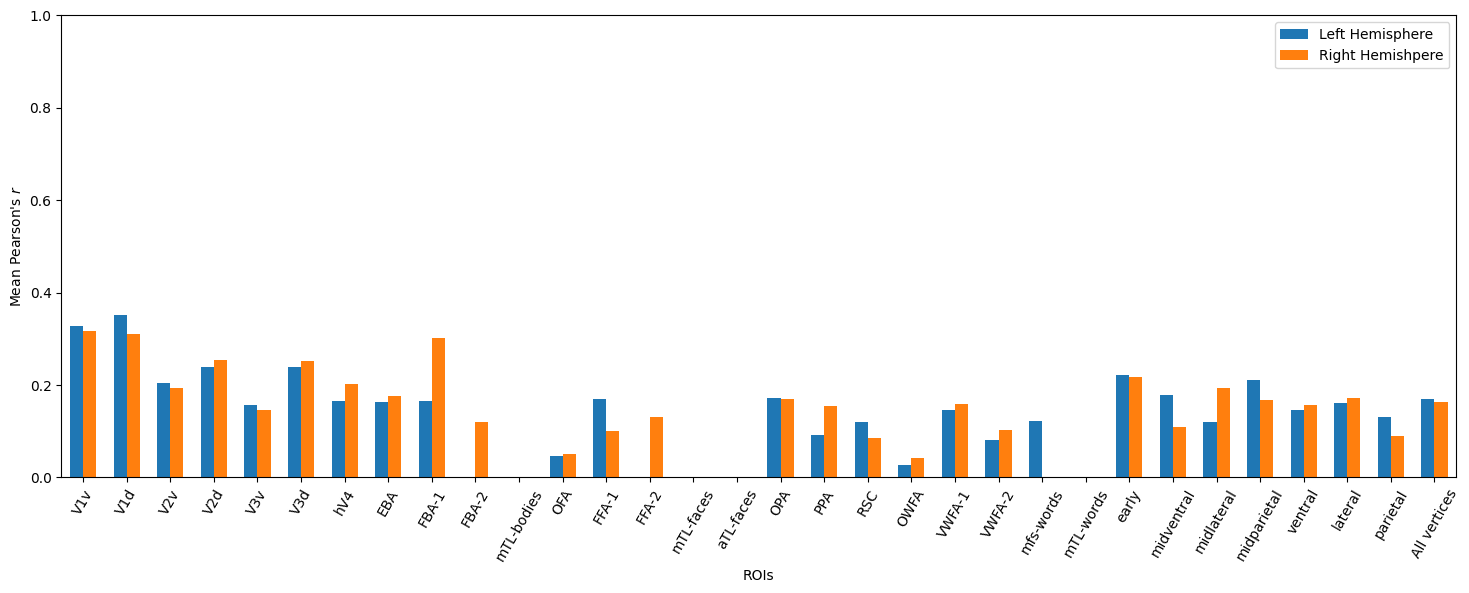

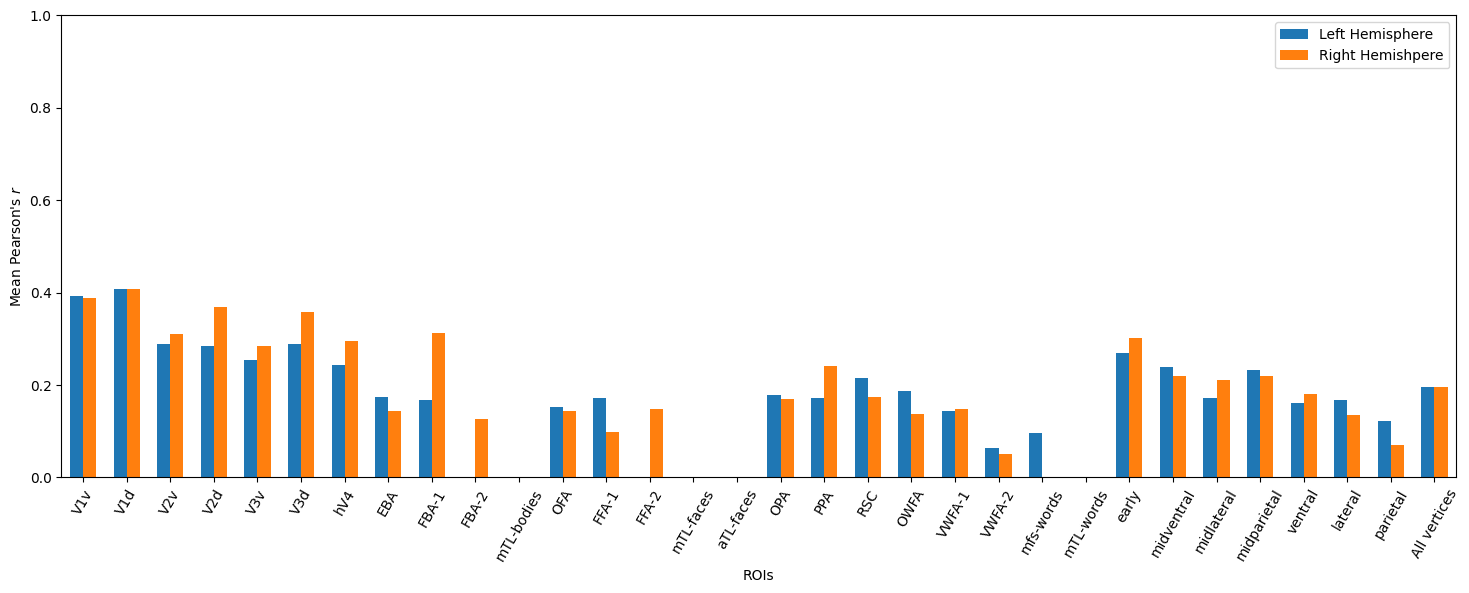

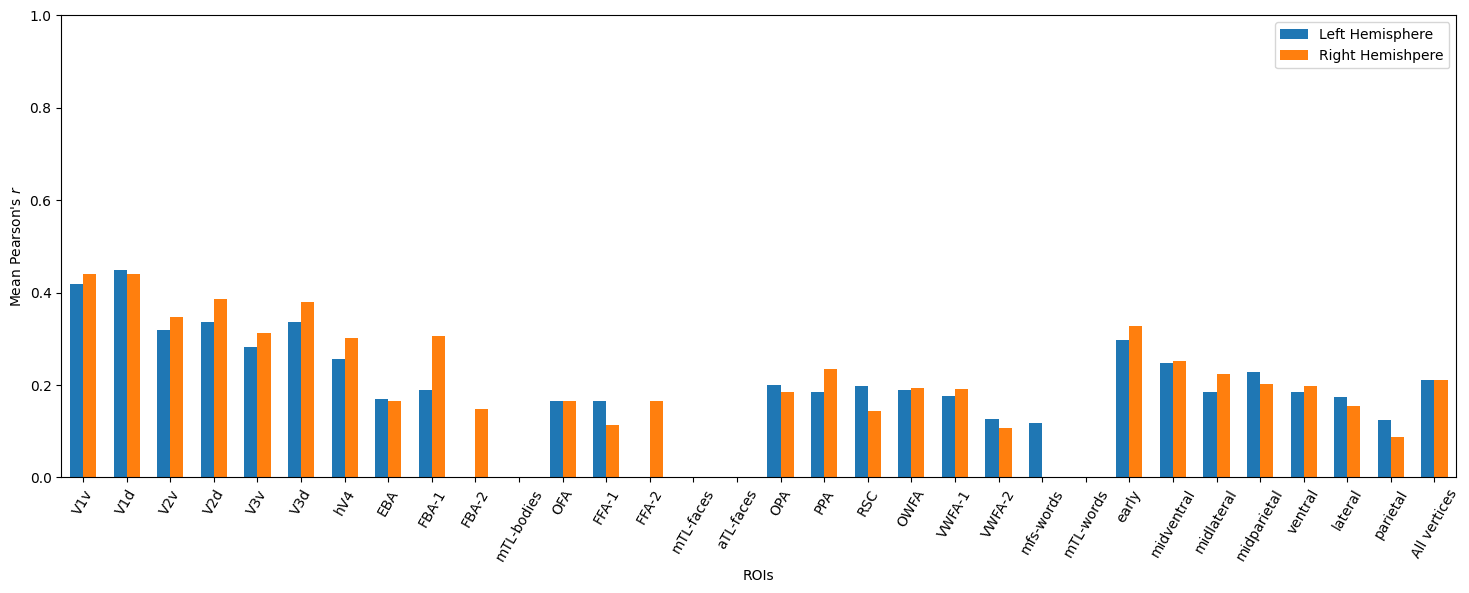

In [20]:
lh_roi_corr_all, rh_roi_corr_all = [], []
for n in pca_dict.keys():
  ftrain, fval, ftest = nsd.extract_features_train_val_test(
                                feature_extractor,
                                (train_imgs_dataloader, val_imgs_dataloader, test_imgs_dataloader),
                                pca_dict[n])
  lh_correlation, rh_correlation = nsd.fit_mapping_correlations(ftrain, fval, ftest,
                                                            lh_fmri_train, rh_fmri_train,
                                                            lh_fmri_val, rh_fmri_val)
  lh_roi_corr, rh_roi_corr = nsd.create_plot(lh_correlation, rh_correlation, args.data_dir)
  lh_roi_corr_all.append(lh_roi_corr)
  rh_roi_corr_all.append(rh_roi_corr)

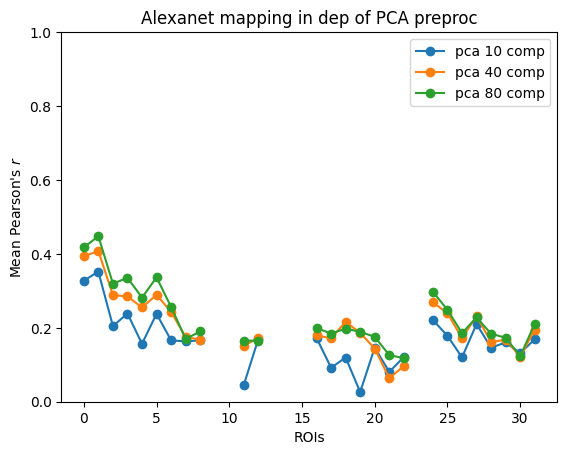

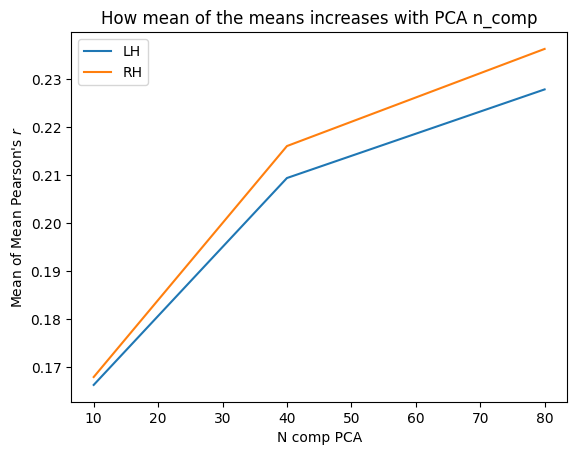

In [21]:
## plotting
for i, n in enumerate(pca_dict.keys()):
  plt.plot(lh_roi_corr_all[i], 'o-', label=f'pca {n} comp')
plt.ylim([0, 1])
plt.xlabel('ROIs')
plt.ylabel('Mean Pearson\'s $r$')
plt.title('Alexanet mapping in dep of PCA preproc')
plt.legend()
plt.show()

plt.plot(pca_dict.keys(), [np.nanmean(k) for k in lh_roi_corr_all], label='LH')
plt.plot(pca_dict.keys(), [np.nanmean(k) for k in rh_roi_corr_all], label='RH')
plt.legend()
plt.title('How mean of the means increases with PCA n_comp')
plt.xlabel('N comp PCA')
plt.ylabel('Mean of Mean Pearson\'s $r$')
plt.show()